In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize


Using TensorFlow backend.


In [6]:

df = pd.read_csv('../../../aparent/data/polyadb_features_pas_3_perturb.csv', sep='\t')

save_dict = np.load("../../../aparent/data/polyadb_features_pas_3_perturb_no_x.npz")
m, l, c, y = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y']

s = np.load('../predictions/apa_perturb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy')

#Mark intronic sites
intron_mask = np.zeros(m.shape)
for k in range(m.shape[1]) :
    intron_mask[:, k] = np.array((df['pas_exists_' + str(k)] & df['site_type_' + str(k)].isin(['Intron', 'Internal_exon'])).astype(int).values, dtype=np.int32)

'''
min_total_c = 10.
total_c = np.sum(c, axis=(1, 2))

s = s[total_c >= min_total_c, :]
m = m[total_c >= min_total_c, :]
l = l[total_c >= min_total_c, :]
c = c[total_c >= min_total_c, :]
y = y[total_c >= min_total_c, :]
'''

min_total_c = 100.
total_c = np.sum(c[..., 1], axis=-1)

min_total_l = 100
min_l = np.min(l + (l == 0.) * 1e6, axis=-1)

max_total_l = 120000
max_l = np.max(l, axis=-1)

s = s[(total_c >= min_total_c) & ((min_l >= min_total_l) & (max_l <= max_total_l)), :]
m = m[(total_c >= min_total_c) & ((min_l >= min_total_l) & (max_l <= max_total_l)), :]
l = l[(total_c >= min_total_c) & ((min_l >= min_total_l) & (max_l <= max_total_l)), :]
c = c[(total_c >= min_total_c) & ((min_l >= min_total_l) & (max_l <= max_total_l)), :]
y = y[(total_c >= min_total_c) & ((min_l >= min_total_l) & (max_l <= max_total_l)), :]
intron_mask = intron_mask[(total_c >= min_total_c) & ((min_l >= min_total_l) & (max_l <= max_total_l)), :]

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("intron_mask.shape = " + str(intron_mask.shape))


s.shape = (6957, 10)
m.shape = (6957, 10)
l.shape = (6957, 10)
c.shape = (6957, 10, 28)
y.shape = (6957, 10, 28)
intron_mask.shape = (6957, 10)


In [6]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type_1 = 'NT'
cell_type_2 = 'CPSF6'

c_1 = c[:, :, cell_type_dict[cell_type_1]]
y_1 = y[:, :, cell_type_dict[cell_type_1]]

c_2 = c[:, :, cell_type_dict[cell_type_2]]
y_2 = y[:, :, cell_type_dict[cell_type_2]]


In [7]:

l_prox_cumulative = np.log(np.cumsum(l[:, ::-1], axis=1) * m[:, ::-1] + 1.)[:, ::-1]
l_cumulative = np.log(np.cumsum(l, axis=1) * m + 1.)
l = np.log(l * m + 1.)


In [8]:

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])


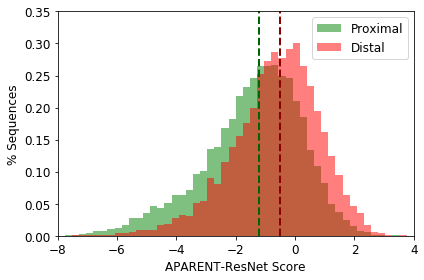

In [9]:
#Proximal-most vs Distal-most PAS scores

s_prox = []
s_dist = []
for i in range(s.shape[0]) :
    s_prox.append(s[i, prox_index[i]])
    s_dist.append(s[i, dist_index[i]])

s_prox = np.array(s_prox)
s_dist = np.array(s_dist)

s_min = -8.
s_max = 4.

prox_hist, bin_edges = np.histogram(s_prox, bins=50, range=(s_min, s_max), density=True)
dist_hist, _ = np.histogram(s_dist, bins=50, range=(s_min, s_max), density=True)

median_prox = np.median(s_prox)
median_dist = np.median(s_dist)

bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width / 2.

f = plt.figure(figsize=(6, 4))

plt.bar(bin_centers, prox_hist, width=bin_width, color='green', alpha=0.5, label='Proximal')
plt.bar(bin_centers, dist_hist, width=bin_width, color='red', alpha=0.5, label='Distal')

plt.axvline(x=median_prox, linestyle='--', linewidth=2, color='darkgreen')
plt.axvline(x=median_dist, linestyle='--', linewidth=2, color='darkred')

plt.xlim(s_min, s_max)
plt.ylim(0, 0.35)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT-ResNet Score", fontsize=12)
plt.ylabel("% Sequences", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.show()



In [10]:

l_dist = []
l_cumulative_dist = []
for i in range(s.shape[0]) :
    l_dist.append(l[i, dist_index[i]])
    l_cumulative_dist.append(l_cumulative[i, dist_index[i]])

l_dist = np.array(l_dist)
l_cumulative_dist = np.array(l_cumulative_dist)


In [11]:
#Proximal-most vs Distal-most PAS scores

s_dists = []
s_dist_means = []
s_dist_medians = []
s_dist_stds = []
for k in range(0, 10) :
    
    s_d = []
    for i in range(s.shape[0]) :
        if dist_index[i] - k >= 0 :
            s_d.append(s[i, dist_index[i] - k])
    
    s_dists.append(np.array(s_d))
    
    s_dist_means.append(np.mean(s_dists[-1]))
    s_dist_medians.append(np.median(s_dists[-1]))
    s_dist_stds.append(np.std(s_dists[-1]))

s_dist_means = np.array(s_dist_means)
s_dist_medians = np.array(s_dist_medians)
s_dist_stds = np.array(s_dist_stds)


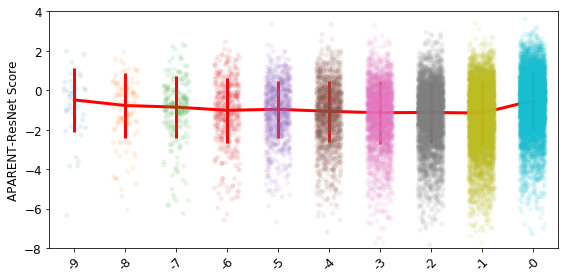

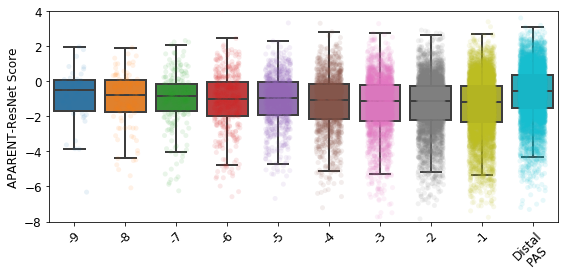

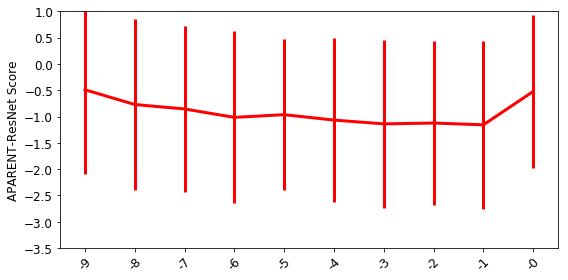

In [12]:

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=s_dists[::-1], alpha=0.1, jitter=0.25)

plt.errorbar(np.arange(10), s_dist_medians[::-1], yerr=s_dist_stds[::-1], linewidth=3, color='red', linestyle='-')

plt.xlim(-0.5, 9.5)
plt.ylim(-8., 4.)

plt.xticks(
    np.arange(10),
    ["-" + str(9-j) if j != 29 else "Distal\nPAS" for j in range(10)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=s_dists[::-1], alpha=0.1, jitter=0.25)
sns.boxplot(data=s_dists[::-1], linewidth=2, fliersize=0.)

plt.xlim(-0.5, 9.5)
plt.ylim(-8., 4.)

plt.xticks(
    np.arange(10),
    ["-" + str(9-j) if j != 9 else "Distal\nPAS" for j in range(10)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(8, 4))

plt.errorbar(np.arange(10), s_dist_medians[::-1], yerr=s_dist_stds[::-1], linewidth=3, color='red', linestyle='-')

plt.xlim(-0.5, 9.5)
plt.ylim(-3.5, 1.)

plt.xticks(
    np.arange(10),
    ["-" + str(9-j) if j != 29 else "Distal\nPAS" for j in range(10)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.show()


Training on tissue = 'NT'
Optimization terminated successfully.
         Current function value: 0.440746
         Iterations: 72
         Function evaluations: 1036
         Gradient evaluations: 74
[ 0.22062028  0.43854309  3.32096749  0.04981409 -0.16482104 -0.26042321
 -0.33639172 -0.53603846 -0.46223476 -0.6262238  -0.60061939 -0.38404641]
- Spearman r = 0.567
- n = 6535


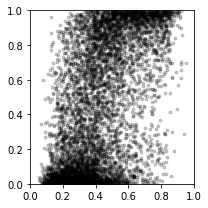

In [13]:
#Fit regression / classification models on native measures

def logistic_model_predict(s, m, l, w_pas, w_len, w_bias) :
    
    score_exp = np.exp(w_pas * s + w_len * l + w_bias) * m
    
    return score_exp / np.sum(score_exp, axis=-1)[:, None]

def logistic_model_mse(w_bundle, s, m, l, y_true) :
    
    w_pas = w_bundle[0]
    w_len = w_bundle[1]
    w_bias = w_bundle[2:2+10]
    
    y_pred = logistic_model_predict(s, m, l, w_pas, w_len, w_bias)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = np.sum(y_true_clip * np.log(y_true_clip / y_pred_clip), axis=-1)
    
    return np.mean(kl)

chosen_tissue_types = ['NT']

model_spearman_rs = np.zeros(len(chosen_tissue_types))

y_preds = []

for tissue_ix in range(len(chosen_tissue_types)) :
    
    print("Training on tissue = '" + chosen_tissue_types[tissue_ix] + "'")
    
    y_tissue = y[..., cell_type_dict[chosen_tissue_types[tissue_ix]]]
    
    w0 = np.zeros(2+10)

    res = minimize(logistic_model_mse, w0, args=(s, m, l_cumulative, y_tissue), method='BFGS', options={'disp': True})

    w_pas = res.x[0]
    w_len = res.x[1]
    w_bias = res.x[2:2+10]
    
    print(res.x)
    
    y_pred_tissue = logistic_model_predict(s, m, l_cumulative, w_pas, w_len, w_bias)
    
    y_preds.append(y_pred_tissue)
    
    spearman_r_val, _ = spearmanr(y_pred_tissue[np.arange(y_tissue.shape[0]), dist_index], y_tissue[np.arange(y_tissue.shape[0]), dist_index])
    model_spearman_rs[tissue_ix] = spearman_r_val
    
    print("- Spearman r = " + str(round(spearman_r_val, 3)))
    print("- n = " + str(y_tissue.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_pred_tissue[np.arange(y_tissue.shape[0]), dist_index], y_tissue[np.arange(y_tissue.shape[0]), dist_index], color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


Training on tissue = 'NT'
Optimization terminated successfully.
         Current function value: 0.428369
         Iterations: 194
         Function evaluations: 6304
         Gradient evaluations: 197
[ 0.16195935  0.2205215   0.27113513  0.27649853  0.30089905  0.3422612
  0.29910731  0.27743239  0.14812727  0.41803411  0.          0.36840614
  0.5678119   0.75460096  0.88534153  1.08738566  1.17036559  1.7220874
  1.78180968  1.13744116  8.98699723  6.38624499  4.44922481  2.48988092
  1.03645783 -1.30337649 -2.23211334 -8.39297332 -9.28219152 -2.13810734]
- Spearman r = 0.586
- n = 6535


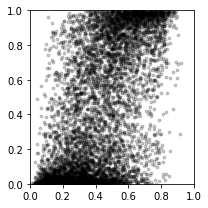

In [14]:
#Fit regression / classification models on native measures (Independent regression weights per PAS)

def logistic_model_predict(s, m, l, w_pas, w_len, w_bias) :
    
    score_exp = np.exp(w_pas * s + w_len * l + w_bias) * m
    
    return score_exp / np.sum(score_exp, axis=-1)[:, None]

def logistic_model_mse(w_bundle, s, m, l, y_true) :
    
    w_pas = w_bundle[0:10]
    w_len = w_bundle[10:20]
    w_bias = w_bundle[20:30]
    
    y_pred = logistic_model_predict(s, m, l, w_pas, w_len, w_bias)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = np.sum(y_true_clip * np.log(y_true_clip / y_pred_clip), axis=-1)
    
    return np.mean(kl)

chosen_tissue_types = ['NT']

model_spearman_rs = np.zeros(len(chosen_tissue_types))

y_preds = []

for tissue_ix in range(len(chosen_tissue_types)) :
    
    print("Training on tissue = '" + chosen_tissue_types[tissue_ix] + "'")
    
    y_tissue = y[..., cell_type_dict[chosen_tissue_types[tissue_ix]]]
    
    w0 = np.zeros(30)

    res = minimize(logistic_model_mse, w0, args=(s, m, l_cumulative, y_tissue), method='BFGS', options={'disp': True})

    w_pas = res.x[0:10]
    w_len = res.x[10:20]
    w_bias = res.x[20:30]
    
    print(res.x)
    
    y_pred_tissue = logistic_model_predict(s, m, l_cumulative, w_pas, w_len, w_bias)
    
    y_preds.append(y_pred_tissue)
    
    spearman_r_val, _ = spearmanr(y_pred_tissue[np.arange(y_tissue.shape[0]), dist_index], y_tissue[np.arange(y_tissue.shape[0]), dist_index])
    model_spearman_rs[tissue_ix] = spearman_r_val
    
    print("- Spearman r = " + str(round(spearman_r_val, 3)))
    print("- n = " + str(y_tissue.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_pred_tissue[np.arange(y_tissue.shape[0]), dist_index], y_tissue[np.arange(y_tissue.shape[0]), dist_index], color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [15]:
#Right-justify feature matrices

s_r = np.zeros(s.shape)
m_r = np.zeros(m.shape)
l_r = np.zeros(l.shape)
l_r = np.zeros(l.shape)
l_cumulative_r = np.zeros(l_cumulative.shape)
l_prox_cumulative_r = np.zeros(l_prox_cumulative.shape)
y_r = np.zeros(y.shape)

dist_index_r = np.copy(dist_index)
dist_index_r[:] = m.shape[1]-1

for i in range(m.shape[0]) :
    
    n_pas = int(np.sum(m[i, :]))
    for j in range(0, m.shape[1]) :
        
        if n_pas-1-j >= 0 and m[i, n_pas-1-j] == 1. :
            s_r[i, m.shape[1]-1-j] = s[i, n_pas-1-j]
            m_r[i, m.shape[1]-1-j] = m[i, n_pas-1-j]
            l_r[i, m.shape[1]-1-j] = l[i, n_pas-1-j]
            l_cumulative_r[i, m.shape[1]-1-j] = l_cumulative[i, n_pas-1-j]
            l_prox_cumulative_r[i, m.shape[1]-1-j] = l_prox_cumulative[i, n_pas-1-j]
            y_r[i, m.shape[1]-1-j] = y[i, n_pas-1-j]


Training on tissue = 'NT'
Optimization terminated successfully.
         Current function value: 0.470230
         Iterations: 71
         Function evaluations: 1022
         Gradient evaluations: 73
[ 0.18833147  0.05246356  0.4663281   0.05033959 -0.09536826 -0.02624563
 -0.07554818 -0.06271259 -0.06491217 -0.0906715  -0.03071318 -0.07051507]
- Spearman r = 0.494
- n = 6535


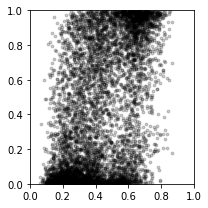

In [16]:
#Fit regression / classification models on native measures (right-justified)

def logistic_model_predict(s, m, l, w_pas, w_len, w_bias) :
    
    score_exp = np.exp(w_pas * s + w_len * l + w_bias) * m
    
    return score_exp / np.sum(score_exp, axis=-1)[:, None]

def logistic_model_mse(w_bundle, s, m, l, y_true) :
    
    w_pas = w_bundle[0]
    w_len = w_bundle[1]
    w_bias = w_bundle[2:2+10]
    
    y_pred = logistic_model_predict(s, m, l, w_pas, w_len, w_bias)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = np.sum(y_true_clip * np.log(y_true_clip / y_pred_clip), axis=-1)
    
    return np.mean(kl)

chosen_tissue_types = ['NT']

model_spearman_rs = np.zeros(len(chosen_tissue_types))

y_preds = []

for tissue_ix in range(len(chosen_tissue_types)) :
    
    print("Training on tissue = '" + chosen_tissue_types[tissue_ix] + "'")
    
    y_tissue_r = y_r[..., cell_type_dict[chosen_tissue_types[tissue_ix]]]
    
    w0 = np.zeros(2+10)

    res = minimize(logistic_model_mse, w0, args=(s_r, m_r, l_cumulative_r, y_tissue_r), method='BFGS', options={'disp': True})

    w_pas = res.x[0]
    w_len = res.x[1]
    w_bias = res.x[2:2+10]
    
    print(res.x)
    
    y_pred_tissue_r = logistic_model_predict(s_r, m_r, l_cumulative_r, w_pas, w_len, w_bias)
    
    y_preds.append(y_pred_tissue_r)
    
    spearman_r_val, _ = spearmanr(y_pred_tissue_r[np.arange(y_tissue_r.shape[0]), dist_index_r], y_tissue_r[np.arange(y_tissue_r.shape[0]), dist_index_r])
    model_spearman_rs[tissue_ix] = spearman_r_val
    
    print("- Spearman r = " + str(round(spearman_r_val, 3)))
    print("- n = " + str(y_tissue_r.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_pred_tissue_r[np.arange(y_tissue_r.shape[0]), dist_index_r], y_tissue_r[np.arange(y_tissue_r.shape[0]), dist_index_r], color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


Training on tissue = 'NT'
Optimization terminated successfully.
         Current function value: 0.436216
         Iterations: 142
         Function evaluations: 4640
         Gradient evaluations: 145
[-0.17600816  0.3162651  -0.11540455 -0.10899695 -0.02801876  0.02917939
  0.03390528  0.14131636  0.25655611  0.31285158  0.         -0.06239363
  0.01491992  0.04230733  0.02329953  0.04954015  0.05567603  0.07515377
  0.11571986  0.46326805  0.70265199  1.13096968  0.34794854  0.28803112
  0.425034    0.33439876  0.24613572  0.1433272  -0.1514824  -3.46702049]
- Spearman r = 0.589
- n = 6535


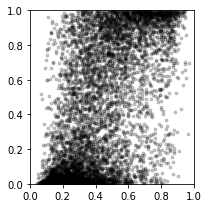

In [17]:
#Fit regression / classification models on native measures (right-justified)

def logistic_model_predict(s, m, l, w_pas, w_len, w_bias) :
    
    score_exp = np.exp(w_pas * s + w_len * l + w_bias) * m
    
    return score_exp / np.sum(score_exp, axis=-1)[:, None]

def logistic_model_mse(w_bundle, s, m, l, y_true) :
    
    w_pas = w_bundle[0:10]
    w_len = w_bundle[10:20]
    w_bias = w_bundle[20:30]
    
    y_pred = logistic_model_predict(s, m, l, w_pas, w_len, w_bias)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = np.sum(y_true_clip * np.log(y_true_clip / y_pred_clip), axis=-1)
    
    return np.mean(kl)

chosen_tissue_types = ['NT']

model_spearman_rs = np.zeros(len(chosen_tissue_types))

y_preds = []

for tissue_ix in range(len(chosen_tissue_types)) :
    
    print("Training on tissue = '" + chosen_tissue_types[tissue_ix] + "'")
    
    y_tissue_r = y_r[..., cell_type_dict[chosen_tissue_types[tissue_ix]]]
    
    w0 = np.zeros(30)

    res = minimize(logistic_model_mse, w0, args=(s_r, m_r, l_cumulative_r, y_tissue_r), method='BFGS', options={'disp': True})

    w_pas = res.x[0:10]
    w_len = res.x[10:20]
    w_bias = res.x[20:30]
    
    print(res.x)
    
    y_pred_tissue_r = logistic_model_predict(s_r, m_r, l_cumulative_r, w_pas, w_len, w_bias)
    
    y_preds.append(y_pred_tissue_r)
    
    spearman_r_val, _ = spearmanr(y_pred_tissue_r[np.arange(y_tissue_r.shape[0]), dist_index_r], y_tissue_r[np.arange(y_tissue_r.shape[0]), dist_index_r])
    model_spearman_rs[tissue_ix] = spearman_r_val
    
    print("- Spearman r = " + str(round(spearman_r_val, 3)))
    print("- n = " + str(y_tissue_r.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_pred_tissue_r[np.arange(y_tissue_r.shape[0]), dist_index_r], y_tissue_r[np.arange(y_tissue_r.shape[0]), dist_index_r], color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [18]:

y_1_prox = []
y_2_prox = []
for i in range(s.shape[0]) :
    y_1_prox.append(y_1[i, prox_index[i]])
    y_2_prox.append(y_2[i, prox_index[i]])

y_1_prox = np.array(y_1_prox)
y_2_prox = np.array(y_2_prox)

logodds_1_prox = np.log(np.clip(y_1_prox, 1e-6, 1. - 1e-6) / (1. - np.clip(y_1_prox, 1e-6, 1. - 1e-6)))
logodds_2_prox = np.log(np.clip(y_2_prox, 1e-6, 1. - 1e-6) / (1. - np.clip(y_2_prox, 1e-6, 1. - 1e-6)))

y_1_dist = []
y_2_dist = []
for i in range(s.shape[0]) :
    y_1_dist.append(y_1[i, dist_index[i]])
    y_2_dist.append(y_2[i, dist_index[i]])

y_1_dist = np.array(y_1_dist)
y_2_dist = np.array(y_2_dist)

logodds_1_dist = np.log(np.clip(y_1_dist, 1e-6, 1. - 1e-6) / (1. - np.clip(y_1_dist, 1e-6, 1. - 1e-6)))
logodds_2_dist = np.log(np.clip(y_2_dist, 1e-6, 1. - 1e-6) / (1. - np.clip(y_2_dist, 1e-6, 1. - 1e-6)))


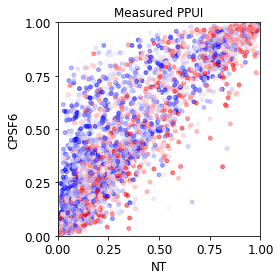

In [19]:

keep_index = ((y_1_prox > 0.01) & (y_1_prox < .99))
keep_index = keep_index & ((y_2_prox > 0.01) & (y_2_prox < .99))

s_prox_std = (s_prox - np.mean(s_prox)) / np.std(s_prox)
s_dist_std = (s_dist - np.mean(s_dist)) / np.std(s_dist)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_1_prox[keep_index], y_2_prox[keep_index], cmap='bwr', c=(s_prox_std - s_dist_std)[keep_index], vmin=-2., vmax=2., s=15, alpha=0.5)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI", fontsize=12)

plt.tight_layout()

plt.show()


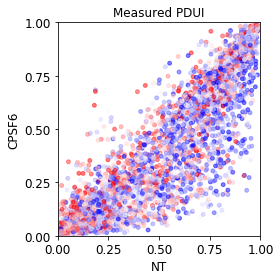

In [20]:

keep_index = ((y_1_dist > 0.01) & (y_1_dist < .99))
keep_index = keep_index & ((y_2_dist > 0.01) & (y_2_dist < .99))

s_prox_std = (s_prox - np.mean(s_prox)) / np.std(s_prox)
s_dist_std = (s_dist - np.mean(s_dist)) / np.std(s_dist)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_1_dist[keep_index], y_2_dist[keep_index], cmap='bwr', c=(s_prox_std - s_dist_std)[keep_index], vmin=-2., vmax=2., s=15, alpha=0.5)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PDUI", fontsize=12)

plt.tight_layout()

plt.show()


In [21]:
#Proximal-most vs Distal-most PAS scores

ys_1_dists = []
ys_1_dist_means = []
ys_1_dist_medians = []
ys_1_dist_stds = []
for k in range(0, 10) :
    
    s_d = []
    for i in range(s.shape[0]) :
        if dist_index[i] - k >= 0 and (y_1[i, dist_index[i] - k] > 0. and y_1[i, dist_index[i] - k] < 1.) :
            s_d.append(np.log(y_1[i, dist_index[i] - k] / (1. - y_1[i, dist_index[i] - k])))
    
    ys_1_dists.append(np.array(s_d))
    
    ys_1_dist_means.append(np.mean(ys_1_dists[-1]))
    ys_1_dist_medians.append(np.median(ys_1_dists[-1]))
    ys_1_dist_stds.append(np.std(ys_1_dists[-1]))

ys_1_dist_means = np.array(ys_1_dist_means)
ys_1_dist_medians = np.array(ys_1_dist_medians)
ys_1_dist_stds = np.array(ys_1_dist_stds)


In [22]:
#Proximal-most vs Distal-most PAS scores

ys_2_dists = []
ys_2_dist_means = []
ys_2_dist_medians = []
ys_2_dist_stds = []
for k in range(0, 10) :
    
    s_d = []
    for i in range(s.shape[0]) :
        if dist_index[i] - k >= 0 and (y_2[i, dist_index[i] - k] > 0. and y_2[i, dist_index[i] - k] < 1.) :
            s_d.append(np.log(y_2[i, dist_index[i] - k] / (1. - y_2[i, dist_index[i] - k])))
    
    ys_2_dists.append(np.array(s_d))
    
    ys_2_dist_means.append(np.mean(ys_2_dists[-1]))
    ys_2_dist_medians.append(np.median(ys_2_dists[-1]))
    ys_2_dist_stds.append(np.std(ys_2_dists[-1]))

ys_2_dist_means = np.array(ys_2_dist_means)
ys_2_dist_medians = np.array(ys_2_dist_medians)
ys_2_dist_stds = np.array(ys_2_dist_stds)


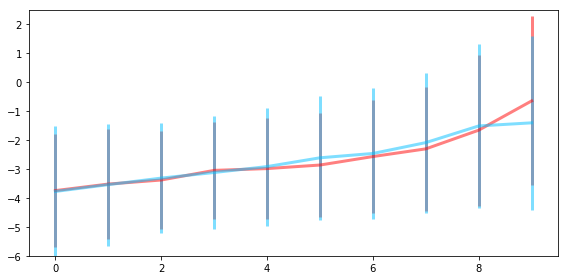

In [23]:

f = plt.figure(figsize=(8, 4))

plt.errorbar(np.arange(10), ys_1_dist_medians[::-1], yerr=ys_1_dist_stds[::-1], alpha=0.5, linewidth=3, color='red', linestyle='-')
plt.errorbar(np.arange(10), ys_2_dist_medians[::-1], yerr=ys_2_dist_stds[::-1], alpha=0.5, linewidth=3, color='deepskyblue', linestyle='-')

plt.xlim(-0.5, 9.5)
plt.ylim(-6.0, 2.5)

plt.tight_layout()

plt.show()
